<center>
<img src="https://2223moodle.isel.pt/pluginfile.php/1/theme_adaptable/logo/1631635830/logo-isel_inv3.png" width="250">
<h3>Licenciatura em Engenharia Informática e Multimédia</h3><br>
<br>
<h2>Aprendizagem Automática (AA)</h3>
<h3>2º Trabalho Laboratorial – Classificação de Críticas de Cinema do IMDb </h3>
<br>

<br>
Trabalho Realizado por:<br>
Gonçalo Silva <b>A48328</b><br>
Diogo Lobo <b>A48168</b><br>
Turma 52D<br><br>
Docente: Gonçalo Xufre <br>
<br>
9 de Dezembro de 2024
</center>


***
<br>
<a id='section0'></a>
<center><h2><b>Índice</b></h2></center>

- [Introdução](#section1)

- [Desenvolvimento](#section2)

  - [Construção do Vocabulário](#subsection21)

  - [Classificação](#subsection22)
      
      - [LogisticRegression](#subsection221)

      - [SVC](#subsection222)

  - [Regressão](#subsection23)

      - [LinearRegression](#subsection231)

      - [SVR](#subsection232)

  - [Bi-Gramas](#subsection24)

  - [Classificação - Bi-Gramas](#subsection25)

      - [LogisticRegression - Bi-Gramas](#subsection251)

      - [SVC - Bi-Gramas](#subsection252)
  
  - [Regressão - Bi-Gramas](#subsection26)

      - [LinearRegression - Bi-Gramas](#subsection261)

      - [SVR - Bi-Gramas](#subsection262)

  - [Comparação dos Resultados](#subsection27)

  - [Clustering](#subsection28)


- [Conclusão](#section3)

- [Bibliografia](#section4)




---
<a id='section1'></a>
## <center><b>Introdução</b></center>
<div style="text-align: justify">

### Enquadramento

No contexto da unidade curricular de Aprendizagem Automática, foi proposto como segundo trabalho prático o desenvolvimento e avaliação de classificadores multi-classe e regressores para a avaliação de criticas de filmes num intervalo de 1 a 4 e 7 a 10 (críticas avaliadas com 5 e 6 foram removidas), como também, a realização de clustering das críticas e análise dos seus resultados.

### Objetivos

1- Treinar e avaliar um classificador multi-classe para prever a pontuação da crítica

2- Treinar e avaliar um regressor para prever a pontuação da crítica

3- Fazer clustering das críticas

### Desenvolvimento

O desenvolvimento do trabalho será realizado com base no seguinte percurso:

#### 1. Construção do vocabulário
A construção do vocabulário é um passo fundamental para o bom desempenho dos modelos analisados. Para tal, precedemos à limpeza dos textos através da função TfidfVectorizer, com e sem a inclusão de bigramas. Usamos ambos os vocabulários construídos nas tarefas seguintes.

#### 2. Classificação e regressão
Para este trabalho escolhemos 2 modelos de classificação e 2 de regressão, LogisticRegression e LinearSVC para a classificação e LinearRegression e SVR para a regressão.

#### 3. Metodologias de teste e métricas de desempenho
Realizamos testes e verificámos os desempenhos dos diferentes classificadores e regressores desenvolvidos, como também, a diferenças destes modelos com e sem bi-gramas.

#### 4. Clustering
Escolhemos o método Kmeans para realizar o clustering, agrupando as críticas de uma forma não supervisionada. Analisámos, também, os diferentes resultados dos agrupamentos deste método.

---
<a id='section2'></a>
## <center><b>Desenvolvimento</b></center>
<div style="text-align: justify">

In [1]:
#Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as aggClus
from scipy.cluster.hierarchy import dendrogram
import itertools

Estas duas funções são utilizadas para mostrar as matrizes de confusão e o relatório de classificação tanto para os classificadores tanto para os regressores.

Sendo que para os classificadores não foi necessário um tratamento especial dos seus resultados para os visualizar, para os regressores isso não acontece.

Isto porque os resultados dos regressores não estão arredondados, ou até dentro do intervalo esperado.

Assim, foi feito o método para arredondar os resultados, colocá-los no intervalo de [1,10] e caso fosse 5 ou 6 era transformado em 4 ou 7, respectivamente.

In [2]:
def plotMatriz(modelo,xtest,ytest,string):
    y_pred = modelo.predict(xtest)
    print(classification_report(ytest, y_pred))
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix(ytest, y_pred),annot=True,fmt='g')
    plt.title(string)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [3]:
def plotMatrizRegression(modelo,xtest,ytest,string):
    y_pred = modelo.predict(xtest)
    # Arredondamento
    y_pred = np.round(y_pred)

    # Limitar os valores no intervalo [1, 10]
    y_pred = np.clip(y_pred, 1, 10)

    y_pred[y_pred == 5] = 4  # Transforma 5 em 4
    y_pred[y_pred == 6] = 7  # Transforma 6 em 7

    print(classification_report(ytest, y_pred))
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix(y_pred,ytest),annot=True,fmt='g')
    plt.title(string)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

---
<a id='subsection21'></a>
## <center><b>Construção do Vocabulário</b></center>
<div style="text-align: justify">

Para preparar os dados para as tarefas da classificação, regressão e  do clustering, começamos por construir o vocabulário. Este passo envolveu limpeza de texto, utilizando os documentos sem stemmers por ao comparar os resultados entre todos, acabou por se obter melhores resultados com os documentos inalterados, a utilização do TfidfVectorizer.


In [4]:
D = pickle.load(open('imdbFull.p','rb'))

In [5]:
Docs = D.data
y = D.target
descr = D.DESCR
print(descr)
print(len(Docs))
print(len(y))


This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.
For more details see: http://ai.stanford.edu/~amaas/data/sentiment/
50000
50000


### Técnicas de Stemming

Foram testados três algoritmos de stemming:

- PorterStemmer

- SnowballStemmer

- LancasterStemmer

Na célula anterior vemos que existem 50000 criticas, e por causa desta dimensão de dados o teste dos algoritmos de stemming demoravam dezenas de minutos a serem executados, assim para evitar o tempo de processamento, decidimos que armazenar os resultados num ficheiro pickle seria o mais adequado.


In [6]:
# from nltk.stem import PorterStemmer,SnowballStemmer,LancasterStemmer

# porterStemFunc = PorterStemmer()
# Docs_PorterStem = [' '.join([porterStemFunc.stem(word) for word in doc.split()]) for doc in Docs]


# snowballSteamFunc = SnowballStemmer('english')
# Docs_SnowballStem = [' '.join([snowballSteamFunc.stem(word) for word in doc.split()]) for doc in Docs]

# lancasterStemFunc = LancasterStemmer()
# Docs_LancasterStem = [' '.join([lancasterStemFunc.stem(word) for word in doc.split()]) for doc in Docs]

# print(Docs_PorterStem[0])
# print(Docs_SnowballStem[0])
# print(Docs_LancasterStem[0])



### Nota:
O código dos stemmers está comentado por não ser utilizado no projeto e ser demorado quando se corre para os documentos completos.

### Processamento e Limpeza de Dados
As críticas foram processadas para remover caracteres indesejados e substituir as quebras de linha (\<br />) por espaços.
Foi utilizado o método re.sub para eliminar caracteres que não fossem letras, garantindo que apenas palavras relevantes permanecessem no texto.


<br />

### Representação com TF-IDF

Para representar os textos de forma numérica, utilizámos a função TfidfVectorizer com os seguintes parâmetros:

min_df=10: Apenas palavras que aparecem em pelo menos 10 documentos foram incluídas no vocabulário.
token_pattern=r'\b\w\w+\b': Foram consideradas palavras com pelo menos duas letras.
Após a transformação, o vocabulário resultante foi utilizado para gerar uma matriz esparsa representando os documentos no espaço TF-IDF.



In [7]:
# print(DocsLancasterStem[0])
DocsReplace = [doc.replace('<br />', ' ') for doc in Docs]
DocsFinal =[re.sub(r'[^a-z-A-Z\u00c0-\u00FF]+',' ',doc)for doc in DocsReplace]
print(Docs[0])
# Tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10,token_pattern=r'\b\w\w+\b').fit(Docs)
Tfidf = TfidfVectorizer(min_df=10,token_pattern=r'\b\w\w+\b').fit(DocsFinal)
X = Tfidf.transform(DocsFinal)
print(X.shape)

Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
(50000, 25759)


### Divisão dos Dados

Os dados foram divididos em conjuntos de treino e teste usando train_test_split com uma proporção de 50% para o conjunto de teste. Adicionalmente, criámos um conjunto de validação a partir do conjunto de treino, separando 20% dos dados. O parâmetro shuffle=False foi utilizado para preservar a ordem dos dados.



In [8]:
DocsTrain, DocsTest, ytrain, ytest = train_test_split(X,y,test_size=0.50,shuffle=False,random_state=18)
DocsValTrain, DocsValTest, yValTrain, yValTest = train_test_split(DocsTrain,ytrain,test_size=0.2,random_state=18,shuffle=False)

---
<a id='subsection22'></a>
## <center><b>Classificação</b></center>
<div style="text-align: justify">

Classificação é a tarefa de prever a qual de um número de categorias um exemplo pertence, podendo ser binária ou multi-classe. No contexto deste trabalho, a classificação foi multi-classe, sendo realizada para prever a pontuação de críticas de filmes em classes definidas (1 a 4 e 7 a 10). O modelo foi treinado com um conjunto de dados previamente dividido e avaliado com dados de teste que o modelo ainda não havia visto, garantindo uma estimativa robusta de desempenho.

Foram utilizados dois algoritmos para esta tarefa: Logistic Regression e Support Vector Classifier (SVC).

<br>

### Nota acerca das matrizes de confusão para uma compreensão correta:
As legendas das classes estão de 0 a 7, o que não corresponde ao intervalo das ratings das critiícas.
Assim, para não haver enganos na compreensão, colocamos aqui a correspondência correta entre as ratings e as classes.

- 0 -> 1
- 1 -> 2
- 2 -> 3
- 3 -> 4
- 4 -> 7
- 5 -> 8
- 6 -> 9
- 7 -> 10


<a id='subsection221'></a>
## <center><b>Logistic Regression</b></center>
<div style="text-align: justify">




*Regressão logística* é uma técnica estatística que tem como objetivo principal prever a probabilidade da ocurrência de um evento multi-classe, tendo em conta um conjunto de dados independentes.

Esta função recebe como alguns dos parâmetros os seguintes:

##### Penalty: {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
| Type | Rule  |    
| :-: | :-: |
| None | no penalty is added |
|'l2', default  | add a L2 penalty term and it is the default choice |
| 'l1' | add a L1 penalty term |
| 'elasticnet' | both L1 and L2 penalty terms are added |

##### tol: float, default=1e-4
Tolerance for stopping criteria.

##### C: float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

##### solver: {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

‘liblinear’ and ‘newton-cholesky’ can only handle binary classification by default. To apply a one-versus-rest scheme for the multiclass setting one can wrapt it with the OneVsRestClassifier.

‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.

##### max_iter: int, default=100
Maximum number of iterations taken for the solvers to converge.





Para encontrar os melhores hiperparâmetros para a Regressão Logística, utilizámos o método de busca em grade (Grid Search) com validação cruzada. Foram avaliados diferentes valores para o parâmetro de regularização C, tolerância tol, e os algoritmos de otimização lbfgs e saga. Através deste processo, identificámos os melhores parâmetros para este cenário.

O código está comentado, pois tal como na cell dos stemmers, é um código que demora muito tempo a ser executado devido ao número elevado de dados.

In [9]:
# param_grid = {
#     'C': [0.1, 1, 10,100],
#     'max_iter': [1000],
#     'tol': [0.0001, 0.001, 0.01, 0.1],
#     'solver': ['lbfgs', 'saga','newton-cg']
# }
# gridSearch = GridSearchCV(LogisticRegression(penalty='l2'),param_grid,cv=5)
# gridSearch.fit(DocsTrain,ytrain)

# bestLogReg = gridSearch.best_estimator_
# print('Melhores parametros: ',gridSearch.best_params_)
# pickle.dump(X,open('X1234Grams.p','wb'))
# pickle.dump(gridSearch,open('gridSearch1234Grams.p','wb'))
# print(bestLogReg.score(DocsTrain,ytrain))
# print(bestLogReg.score(DocsTest,ytest))

Com os melhores parâmetros agora adquiridos, avançamos para a validação do modelo

## Logsitic Regression - Validação

In [10]:
LogReg = LogisticRegression(penalty='l2',C=1,max_iter=1000,tol=0.0001,solver='lbfgs',random_state=18)
LogReg.fit(DocsValTrain,yValTrain)
print(LogReg.score(DocsValTrain,yValTrain))
print(LogReg.score(DocsValTest,yValTest))

0.7064
0.4324


              precision    recall  f1-score   support

           1       0.54      0.85      0.66      1018
           2       0.29      0.07      0.11       454
           3       0.32      0.14      0.19       481
           4       0.41      0.38      0.39       539
           7       0.35      0.26      0.29       525
           8       0.28      0.26      0.27       618
           9       0.19      0.04      0.06       441
          10       0.44      0.74      0.55       924

    accuracy                           0.43      5000
   macro avg       0.35      0.34      0.32      5000
weighted avg       0.38      0.43      0.38      5000



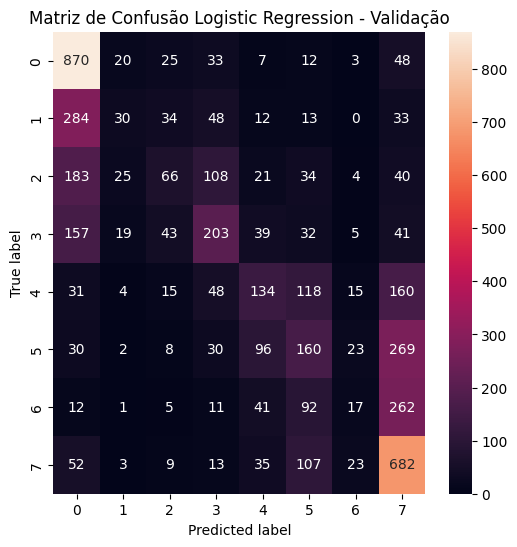

In [11]:
plotMatriz(LogReg,DocsValTest,yValTest,'Matriz de Confusão Logistic Regression - Validação')

Os resultados da validação do modelo Logistic Regression apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevados para a classe "1" (0.54 e 0.85, respetivamente), enquanto outras classes, como a "2", apresentam valores significativamente inferiores (0.29 e 0.07). A accuracy global é de 43%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias (por exemplo, "4", "5" e "6"), indicando que o modelo enfrenta desafios em distinguir estas categorias, possivelmente devido à semelhança das críticas nestas faixas. As classes situadas nas extremidades, apresentam melhor o desempenho, sugerindo que possuem características mais distintas.

Com a validação feita, passamos então à fase de teste deste modelo.

## Logistic Regression - Teste

In [12]:
LogReg.fit(DocsTrain,ytrain)
print(LogReg.score(DocsTrain,ytrain))
print(LogReg.score(DocsTest,ytest))

0.69212
0.42588


              precision    recall  f1-score   support

           1       0.53      0.82      0.64      5022
           2       0.21      0.06      0.09      2302
           3       0.27      0.12      0.17      2541
           4       0.32      0.33      0.33      2635
           7       0.33      0.25      0.28      2307
           8       0.27      0.24      0.26      2850
           9       0.23      0.04      0.07      2344
          10       0.48      0.77      0.59      4999

    accuracy                           0.43     25000
   macro avg       0.33      0.33      0.30     25000
weighted avg       0.37      0.43      0.37     25000



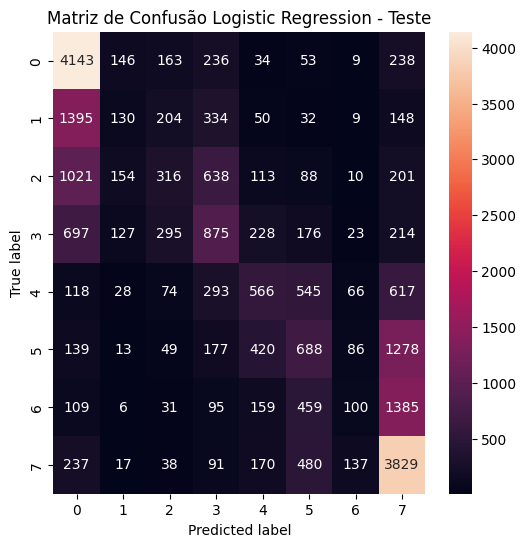

In [13]:
plotMatriz(LogReg,DocsTest,ytest,'Matriz de Confusão Logistic Regression - Teste')

Os resultados do modelo Logistic Regression para o conjunto de teste mostram um desempenho consistente com o conjunto de validação, apresentando uma accuracy de 43%. A classe "1" mantém um desempenho relativamente superior, com uma precisão de 0.53 e um recall de 0.82, indicando que o modelo consegue identificar corretamente a maioria das instâncias desta classe, embora ainda existam erros. Por outro lado, classes como "2", "3" e "8" continuam a apresentar desempenho muito inferior, com valores de recall abaixo de 0.10, demonstrando que o modelo tem dificuldade em distinguir corretamente estas categorias. A matriz de confusão revela novamente uma confusão maior entre classes intermediárias (como "4", "5" e "6").

---

<a id='subsection222'></a>
## <center><b>LinearSVC- Linear Support Vector Classification</b></center>
<div style="text-align: justify">

LinearSVC é um algoritmo que tenta encontrar um hiperplano para maximizar a distancia entre as amostras classificadas.

Esta função recebe como aguns dos parâmetros os seguintes:

#### penalty: {'l1', 'l2'}, default='l2'
Specifies the norm used in the penalization. The 'l2' penalty is the standard used in SVC. The 'l1' leads to coef_ vectors that are sparse.

#### loss: {'hinge','squared_hinge'}, default='squared_hinge'
Specifies the loss functions. 'hinge' is the standard SVM loss (used e.g. by the SVC class) while 'squared_hinge' is the square of the hinge loss.

#### dual: 'auto' or bool, default='auto'
Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features. dual="auto" will choose the value of the parameter automatically, based on the values of n_samples, n_features, loss, multi_class and penalty. If n_samples < n_features and optimizer supports chosen loss, multi_class and penalty, then dual will be set to True, otherwise it will be set to False.

#### tol: float, default=1e-4
Tolerance for stopping criteria

#### C: float, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

#### fit_intercept: bool, default=True
Whether or not to fit an intercept. If set to True, the feature vector is extended to include an intercept term: [x_1, ..., x_n, 1], where 1 corresponds to the intercept. If set to False, no intercept will be used in calculations (i.e. data is expected to be already centered).

#### class_weight: dict or 'balanced', default='None
Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

#### max_iter: int, default=1000
The maximum number of iterations to be run.



Para encontrar os melhores hiperparâmetros para o LinearSVC, utilizámos o método de busca em grade (Grid Search) com validação cruzada. A grelha incluía parâmetros importantes, como o tipo de regularização (penalty), função de perda (loss), escolha entre otimização dual ou primal (dual), o peso das classes (class_weight), e o número máximo de iterações (max_iter), entre outros. Através deste processo, identificámos os melhores parâmetros para este cenário.



In [14]:
# from sklearn.svm import LinearSVC
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'penalty': ['l1', 'l2'],                # Regularization type
#     'loss': ['hinge', 'squared_hinge'],     # Loss function
#     'dual': [True, False],                  # Dual or primal optimization
#     'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
#     'fit_intercept': [True, False],         # Whether to fit an intercept
#     'class_weight': [None, 'balanced'],    # Class weights
#     'max_iter': [1000, 5000, 10000]        # Maximum number of iterations
# }

# svc = LinearSVC(C=.1,max_iter=1000,dual=False,fit_intercept=False,penalty='l2',loss='squared_hinge',class_weight=None,random_state=18)
# # gridSearch = GridSearchCV(LinearSVC(), param_grid, cv=5)

# svc.fit(DocsTrain, ytrain)

# # bestSVM = gridSearch.best_estimator_

# # print('Melhores parâmetros: ', gridSearch.best_params_)
# print('Score treino: ', svc.score(DocsTrain, ytrain))
# print('Score teste: ', svc.score(DocsTest,ytest))

## SVC - Validação

In [15]:
svc = LinearSVC(C=.1,max_iter=1000,dual=False,fit_intercept=False,penalty='l2',loss='squared_hinge',class_weight=None,random_state=18)

svc.fit(DocsValTrain, yValTrain)

print('Score treino: ', svc.score(DocsValTrain, yValTrain))
print('Score teste: ', svc.score(DocsValTest,yValTest))

Score treino:  0.69085
Score teste:  0.429


              precision    recall  f1-score   support

           1       0.51      0.88      0.65      1018
           2       0.33      0.06      0.10       454
           3       0.30      0.09      0.14       481
           4       0.42      0.35      0.38       539
           7       0.35      0.26      0.30       525
           8       0.28      0.23      0.25       618
           9       0.19      0.03      0.06       441
          10       0.44      0.76      0.56       924

    accuracy                           0.43      5000
   macro avg       0.35      0.33      0.30      5000
weighted avg       0.38      0.43      0.36      5000



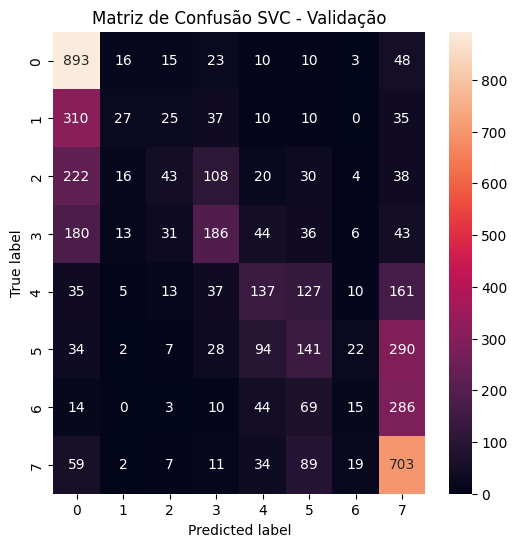

In [16]:
plotMatriz(svc,DocsValTest,yValTest,'Matriz de Confusão SVC - Validação')

Os resultados da validação do modelo LinearSVC apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevadas para a classe "1" (0.51 e 0.88, respetivamente), enquanto outras classes, como a classe "9", apresentam valores significativamente inferiores (0.19 e 0.03). A accuracy global é de 43%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias como as "1","2" e "3" que marcam muitas das suas críticas na classe "0", indicando que o modelo enfrenta dificuldades em distinguir entre estas categorias, sendo possivel observar o mesmo para as classes "4","5" e "6" que marcam muitas das suas críticas na classe "7".

## SVC - Teste

In [17]:
svc.fit(DocsTrain,ytrain)
print(svc.score(DocsTrain,ytrain))
print(svc.score(DocsTest,ytest))

0.67276
0.42436


              precision    recall  f1-score   support

           1       0.50      0.86      0.63      5022
           2       0.18      0.04      0.06      2302
           3       0.26      0.09      0.13      2541
           4       0.33      0.32      0.32      2635
           7       0.32      0.23      0.27      2307
           8       0.28      0.21      0.24      2850
           9       0.22      0.03      0.06      2344
          10       0.48      0.79      0.59      4999

    accuracy                           0.42     25000
   macro avg       0.32      0.32      0.29     25000
weighted avg       0.35      0.42      0.36     25000



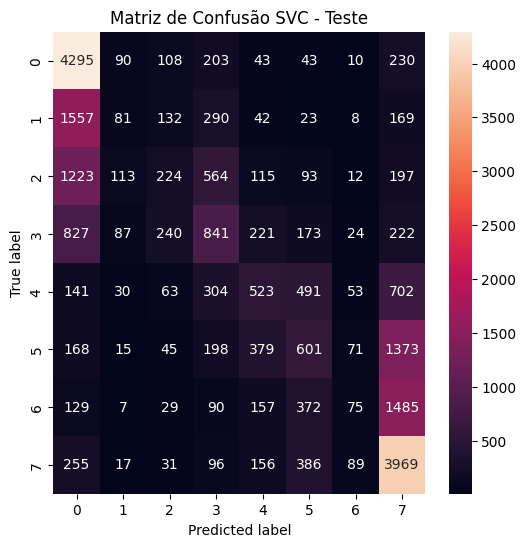

In [18]:
plotMatriz(svc,DocsTest,ytest,'Matriz de Confusão SVC - Teste')

Os resultados de teste do modelo LinearSVC apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevadas para a classe "1" (0.50 e 0.86, respetivamente), enquanto outras classes, como a classe "2", apresentam valores significativamente inferiores (0.18 e 0.04). A accuracy global é de 42%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias como as "1","2" e "3" que marcam muitas das suas críticas na classe "0", indicando que o modelo enfrenta dificuldades em distinguir entre estas categorias, sendo possivel observar o mesmo para as classes "4","5" e "6" que marcam muitas das suas críticas na classe "7".

---
<a id='subsection23'></a>
## <center><b>Regressão</b></center>
<div style="text-align: justify">

Regressão é uma técnica de aprendizagem supervisionada utilizada para prever valores contínuos com base em variáveis independentes. O objetivo principal de um algoritmo de regressão é modelar a relação entre as variáveis, minimizando os erros entre os valores reais e os valores previstos ao traçar uma curva de melhor ajuste entre os dados. Esta técnica é muito utilizada em cenários onde é necessário fazer previsões quantitativas, como análise financeira, previsão de vendas ou avaliação de preços.

No contexto deste trabalho, a regressão foi aplicada para prever a pontuação de críticas de filmes com base no vocabulário construído.

Foram utilizados dois algoritmos:
- Linear Regression
- Support Vector Regressor (SVR)

<a id='subsection231'></a>
## <center><b>LinearSVR- Linear Support Vector Regression</b></center>
<div style="text-align: justify">

LinearSVR é um algoritmo que tenta encontrar um hiperplano que minimiza os erros de predição em um espaço contínuo, ao mesmo tempo que considera uma margem de tolerância para os desvios entre os valores reais e previstos.


#### epsilon: float, default=0.0
Epsilon parameter in the epsilon-insensitive loss function. Note that the value of this parameter depends on the scale of the target variable y. If unsure, set epsilon=0.

#### C: float, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

#### loss: {'epsilon_insensitive','squared_epsilon_insensitive'}, default='epsilon_insensitive'
Specifies the loss function. The epsilon-insensitive loss (standard SVR) is the L1 loss, while the squared epsilon-insensitive loss ('squared_epsilon_insensitive') is the L2 loss.

#### dual: “auto” or bool, default=”auto”
Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features. dual="auto" will choose the value of the parameter automatically, based on the values of n_samples, n_features and loss. If n_samples < n_features and optimizer supports chosen loss, then dual will be set to True, otherwise it will be set to False.

#### max_iter: int, default=1000
The maximum number of iterations to be run.



Para identificar os melhores hiperparâmetros para o modelo LinearSVR, utilizámos o método deGrid Search com validação cruzada. A grelha de parâmetros incluía opções como o valor de epsilon, que controla a margem de tolerância para erros, a força da regularização (C), o número máximo de iterações (max_iter), o tipo de função de perda (loss) entre epsilon_insensitive e squared_epsilon_insensitive, e a escolha entre a resolução dual ou primal (dual).

In [19]:
# linearSVR = LinearSVR(random_state=18)
# param_grid = {
#     'epsilon': [0.01, 0.1, 0.2, 0.5, 1.0],
#     'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
#     'max_iter': [1000, 5000, 10000, 20000],
#     'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
#     'dual': [True, False]
# }
# gridSVR = GridSearchCV(linearSVR,param_grid=param_grid,cv=5)
# gridSVR.fit(DocsTrain,ytrain)

# bestSVR = gridSVR.best_estimator_
# print('Melhores params: ', gridSVR.best_params_)
# pickle.dump(X,open('XSVR.p','wb'))
# pickle.dump(gridSVR,open('GridSVR.p','wb'))
# print(bestSVR.score(DocsTrain,ytrain))
# print(bestSVR.score(DocsTest,ytest))

## SVR - Validação

              precision    recall  f1-score   support

           1       0.69      0.26      0.37      1018
           2       0.18      0.16      0.17       454
           3       0.17      0.19      0.18       481
           4       0.23      0.49      0.31       539
           7       0.20      0.50      0.29       525
           8       0.25      0.24      0.24       618
           9       0.21      0.21      0.21       441
          10       0.61      0.15      0.24       924

    accuracy                           0.26      5000
   macro avg       0.32      0.27      0.25      5000
weighted avg       0.38      0.26      0.27      5000



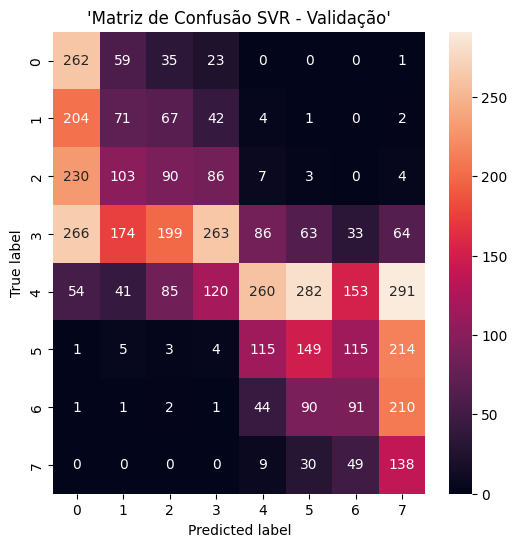

Score (treino): 0.7439071813734789
Score (teste): 0.6259111618349971


In [20]:
linearSVR =LinearSVR(C=1.0,dual=True,epsilon=0.5,loss='epsilon_insensitive',max_iter=2000,random_state=18)
linearSVR.fit(DocsValTrain,yValTrain)

plotMatrizRegression(linearSVR,DocsValTest,yValTest,"'Matriz de Confusão SVR - Validação'")
# Avaliar o modelo no conjunto de treino e teste
print("Score (treino):", linearSVR.score(DocsValTrain, yValTrain))
print("Score (teste):", linearSVR.score(DocsValTest, yValTest))


Os resultados de validação do modelo LinearSVR apresentam um desempenho variável entre as classes, com uma precisão mais elevada para a classe "1" (0.69) sendo que a recall é mais elevada na classe "7" com 0.50. A accuracy glboal é de 26% o que pode indicar este modelo não ser adequado para este tipo de problemas. Na matriz de confusão existe uma maior variação de resultados podendo observar nas classes 3 e 4 (4 e 7 na classes do problema) onde acabam por prever um bocado por todas as classes existentes, a 3 com as 3 primeiras classes e a 4 com as 3 ultimas classes.

## SVR - Teste

              precision    recall  f1-score   support

           1       0.66      0.24      0.35      5022
           2       0.20      0.16      0.17      2302
           3       0.19      0.19      0.19      2541
           4       0.22      0.52      0.31      2635
           7       0.18      0.54      0.27      2307
           8       0.21      0.21      0.21      2850
           9       0.20      0.15      0.17      2344
          10       0.64      0.13      0.22      4999

    accuracy                           0.25     25000
   macro avg       0.31      0.27      0.24     25000
weighted avg       0.38      0.25      0.25     25000



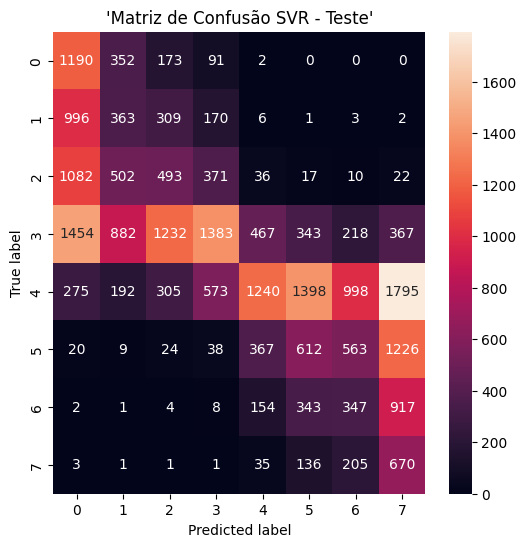

0.7408412746332026
0.6065147392060002


In [21]:
linearSVR.fit(DocsTrain,ytrain)


plotMatrizRegression(linearSVR,DocsTest,ytest,"'Matriz de Confusão SVR - Teste'")

print(linearSVR.score(DocsTrain,ytrain))
print(linearSVR.score(DocsTest,ytest))

Os resultados de teste do modelo LinearSVR apresentam um desempenho variável entre as classes, com uma precisão mais elevada para a classe "1" (0.66) sendo que a recall é mais elevada na classe "7" com 0.54. A accuracy glboal é de 25% o que pode indicar este modelo não ser adequado para este tipo de problemas, tendo ainda uma pior percentagem que na validação. Na matriz de confusão existe uma maior variação de resultados podendo-se observar nas classes 3 e 4 (4 e 7 na classes do problema) onde acabam por prever um bocado por todas as classes existentes, a "3" com as 3 primeiras classes e a "4" com as 3 últimas classes.

---

<a id='subsection232'></a>
## <center><b>Linear Regression</b></center>
<div style="text-align: justify">

Linear Regression é um modelo que tenta prever o valor de uma variável tendo em base o valor de outra variável.

#### fit_intercept: bool, default=True
Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).

#### copy_X: bool, default=True
If True, X will be copied; else, it may be overwritten.

#### positive: bool, default=False
When set to True, forces the coefficients to be positive. This option is only supported for dense arrays.



Os melhores parametros para o Linear Regression foram obtidos sem Grid Search, porque este método não tem tanta diversidade de parâmetros possíveis.

## Linear Regression - Validação

              precision    recall  f1-score   support

           1       0.37      0.42      0.39      1018
           2       0.12      0.08      0.10       454
           3       0.10      0.06      0.07       481
           4       0.12      0.16      0.14       539
           7       0.12      0.15      0.13       525
           8       0.16      0.10      0.12       618
           9       0.14      0.09      0.11       441
          10       0.33      0.41      0.37       924

    accuracy                           0.23      5000
   macro avg       0.18      0.18      0.18      5000
weighted avg       0.21      0.23      0.22      5000



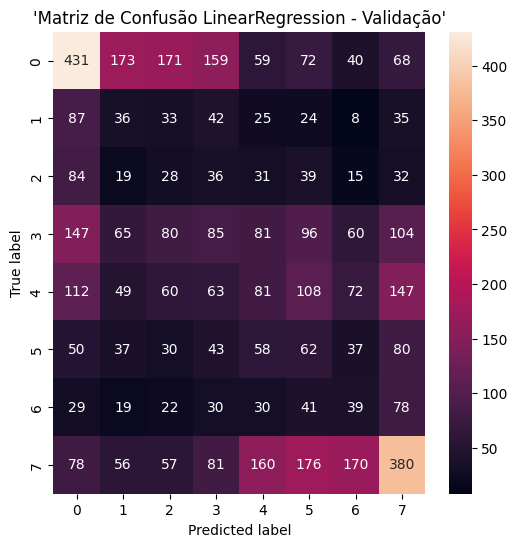

Score treino:  0.9999979239265767
Score validação:  -1.1849179353318142


In [22]:
linearRegression = LinearRegression(copy_X=True,fit_intercept=True,positive=False)

linearRegression.fit(DocsValTrain, yValTrain)

plotMatrizRegression(linearRegression,DocsValTest,yValTest,"'Matriz de Confusão LinearRegression - Validação'")

print('Score treino: ', linearRegression.score(DocsValTrain, yValTrain))
print('Score validação: ', linearRegression.score(DocsValTest, yValTest))

Os resultados de validação do modelo Linear Regression apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevados para a classe "1" (0.37 e 0.42, respetivamente). A accuracy glboal é de 23%, sendo o pior resultado de accuracy na validação entre os 4 modelos testados. Na matriz de confusão existe uma maior variação de resultados podendo observar na classe 0 (1 real) onde se preveu que muitos dessas críticas fizessem parte das classes 1, 2 e 3, igual à classe 7 (10 real) onde se preveu muitas das críticas nas classes 4,5 e 6.

## Linear Regression - Teste

              precision    recall  f1-score   support

           1       0.23      0.49      0.32      5022
           2       0.14      0.04      0.06      2302
           3       0.15      0.04      0.06      2541
           4       0.13      0.06      0.08      2635
           7       0.11      0.06      0.08      2307
           8       0.12      0.03      0.04      2850
           9       0.11      0.03      0.04      2344
          10       0.24      0.46      0.32      4999

    accuracy                           0.21     25000
   macro avg       0.15      0.15      0.12     25000
weighted avg       0.17      0.21      0.16     25000



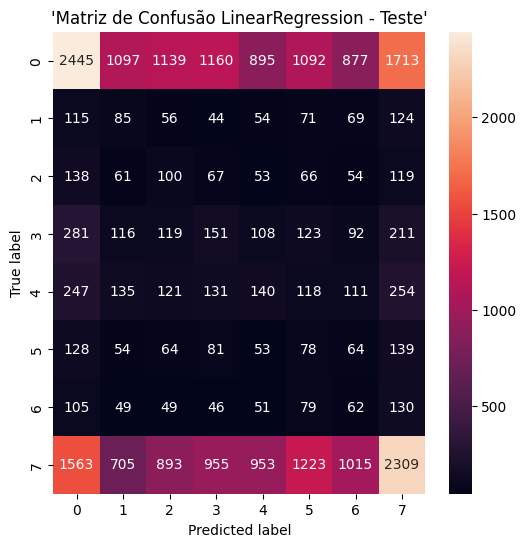

0.9999808132405391
-29.94399313225857


In [23]:
linearRegression.fit(DocsTrain,ytrain)
plotMatrizRegression(linearRegression,DocsTest,ytest,"'Matriz de Confusão LinearRegression - Teste'")
print(linearRegression.score(DocsTrain,ytrain))
print(linearRegression.score(DocsTest,ytest))

Os resultados de teste do modelo Linear Regression apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevados para a classe "1" (0.23 e 0.49, respetivamente). A accuracy glboal é de 21%, sendo o pior resultado de accuracy no teste entre os 4 modelos testados. Na matriz de confusão existe uma maior variação de resultados podendo observar nas classes 0 e 7 (1 e 10 reais) onde se preveu que muitas dessas críticas tivessem valores diferentes, sendo que no teste foi entre os 8 valores possiveis e não só nos 3 mais valores mais próximos à classificação real.

---

<a id='subsection24'></a>
## <center><b>Bi-Gramas</b></center>
<div style="text-align: justify">

Uma das limitações da representação Bag of Words (BoW) é que descarta a informação sobre a ordem das palavras, o que pode ser crucial para compreender o contexto de um texto. Uma forma de mitigar essa limitação é incluir na representação BoW sequências de duas ou mais palavras, conhecidas como n-gramas, que capturam parte da informação contextual dos documentos.

Neste trabalho, optámos por utilizar bi-gramas (sequências de duas palavras consecutivas) para enriquecer a representação dos dados textuais. A partir desta abordagem, os classificadores e regressores foram novamente treinados e avaliados. Os seus desempenhos serão comparados com os obtidos anteriormente, de forma a analisar a inclusão de bi-gramas nos resultados.

## Construção do Vocabulário com Bi-gramas

In [24]:
DocsReplace_bg = [doc.replace('<br />', ' ') for doc in Docs]
Docs_bg =[re.sub(r'[^a-z-A-Z\u00c0-\u00FF]+',' ',doc)for doc in DocsReplace_bg]
print(Docs_bg[0])
Tfidf_bg = TfidfVectorizer(ngram_range=(1,2),min_df=10,token_pattern=r'\b\w\w+\b').fit(Docs_bg)
# Tfidf = TfidfVectorizer(min_df=10,token_pattern=r'\b\w\w+\b').fit(Docs)
X_bg = Tfidf_bg.transform(Docs_bg)

Zero Day leads you to think even re-think why two boys young men would do what they did - commit mutual suicide via slaughtering their classmates It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction It is not a perfect movie but given what money time the filmmaker and actors had - it is a remarkable product In terms of explaining the motives and actions of the two young suicide murderers it is better than Elephant - in terms of being a film that gets under our rationalistic skin it is a far far better film than almost anything you are likely to see Flawed but honest with a terrible honesty 


In [25]:
DocsTrain_bg, DocsTest_bg, ytrain_bg, ytest_bg = train_test_split(X_bg,y,test_size=0.50,shuffle=False,random_state=18)
DocsValTrain_bg, DocsValTest_bg, yValTrain_bg, yValTest_bg = train_test_split(DocsTrain_bg,ytrain_bg,test_size=0.2,random_state=18,shuffle=False)

---

<a id='subsection25'></a>
## <center><b>Classificação - Bi-Gramas</b></center>
<div style="text-align: justify">

## Logistic Regression - Bi-Gramas - Validação

In [26]:
LogReg_bg = LogisticRegression(penalty='l2',C=1,max_iter=1000,tol=0.0001,solver='lbfgs',random_state=18)
LogReg_bg.fit(DocsValTrain_bg,yValTrain_bg)
print(LogReg_bg.score(DocsValTrain_bg,yValTrain_bg))
print(LogReg_bg.score(DocsValTest_bg,yValTest_bg))

0.81
0.4336


              precision    recall  f1-score   support

           1       0.51      0.89      0.65      1018
           2       0.27      0.03      0.06       454
           3       0.28      0.07      0.12       481
           4       0.40      0.36      0.38       539
           7       0.37      0.23      0.29       525
           8       0.31      0.25      0.28       618
           9       0.20      0.02      0.04       441
          10       0.44      0.79      0.56       924

    accuracy                           0.43      5000
   macro avg       0.35      0.33      0.30      5000
weighted avg       0.37      0.43      0.36      5000



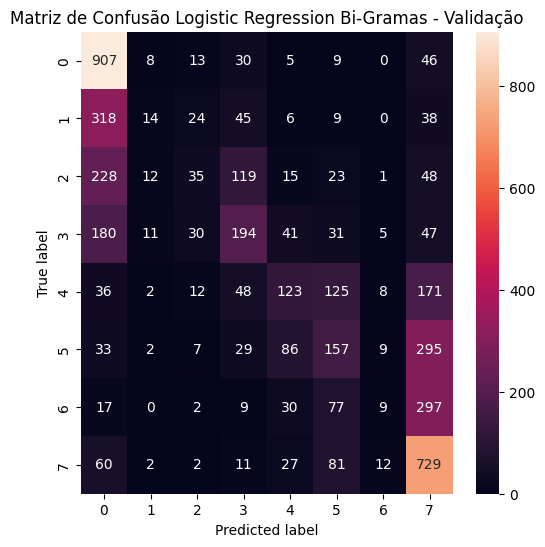

In [27]:
plotMatriz(LogReg_bg,DocsValTest_bg,yValTest_bg,'Matriz de Confusão Logistic Regression Bi-Gramas - Validação')

Os resultados da validação do modelo Logistic Regression com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevados para a classe "1" (0.51 e 0.89, respetivamente), enquanto outras classes, como a "2", apresentam valores significativamente inferiores (0.27 e 0.03). A accuracy global é de 43%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias (por exemplo, "4", "5" e "6"), sendo o mesmo problema observado para o mesmo modelo sem a utilização de bi-gramas, indicando que o modelo enfrenta desafios em distinguir estas categorias, possivelmente devido à semelhança das críticas nestas faixas. As classes situadas nas extremidades, apresentam melhor o desempenho, sugerindo que possuem características mais distintas.

Com a validação feita, passamos então à fase de teste deste modelo.

## Logistic Regression - Bi-Gramas - Teste

In [28]:
LogReg_bg.fit(DocsTrain_bg,ytrain_bg)
print(LogReg_bg.score(DocsTrain_bg,ytrain_bg))
print(LogReg_bg.score(DocsTest_bg,ytest_bg))

0.80444
0.43688


              precision    recall  f1-score   support

           1       0.51      0.87      0.64      5022
           2       0.23      0.03      0.05      2302
           3       0.30      0.10      0.15      2541
           4       0.34      0.34      0.34      2635
           7       0.34      0.22      0.27      2307
           8       0.28      0.24      0.26      2850
           9       0.23      0.02      0.03      2344
          10       0.48      0.82      0.60      4999

    accuracy                           0.44     25000
   macro avg       0.34      0.33      0.29     25000
weighted avg       0.37      0.44      0.36     25000



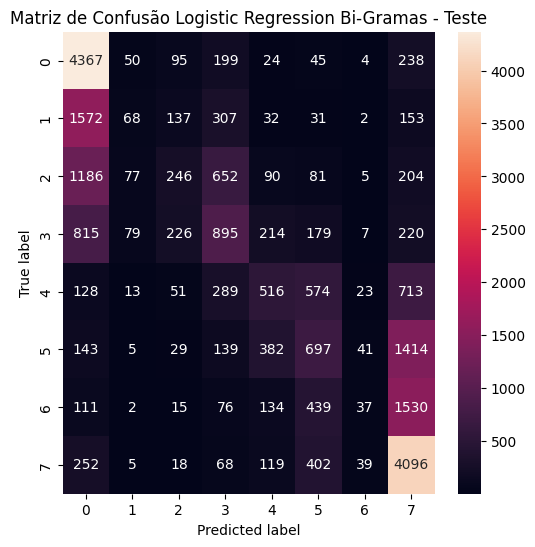

In [29]:
plotMatriz(LogReg_bg,DocsTest_bg,ytest_bg,'Matriz de Confusão Logistic Regression Bi-Gramas - Teste')

Os resultados do modelo Logistic Regression para o conjunto de teste mostram um desempenho consistente com o conjunto de validação, apresentando uma accuracy de 44%. A classe "1" mantém um desempenho relativamente superior, com uma precisão de 0.51 e um recall de 0.87, indicando que o modelo consegue identificar corretamente a maioria das instâncias desta classe, embora ainda existam erros. Por outro lado, classes como "2" e "3" continuam a apresentar desempenho muito inferior, com valores de recall abaixo de 0.10, demonstrando que o modelo tem dificuldade em distinguir corretamente estas categorias. A matriz de confusão revela novamente uma confusão maior entre classes intermediárias (como "4", "5" e "6").

---

## SVC - Bi-Gramas - Validação

In [30]:
svc_bg = LinearSVC(C=.1,max_iter=1000,dual=False,fit_intercept=False,penalty='l2',loss='squared_hinge',class_weight=None,random_state=18)

svc_bg.fit(DocsValTrain_bg, yValTrain_bg)

print('Score treino: ', svc_bg.score(DocsValTrain_bg, yValTrain_bg))
print('Score teste: ', svc_bg.score(DocsValTest_bg,yValTest_bg))

Score treino:  0.8045
Score teste:  0.4302


              precision    recall  f1-score   support

           1       0.49      0.90      0.64      1018
           2       0.39      0.03      0.06       454
           3       0.27      0.06      0.10       481
           4       0.44      0.34      0.38       539
           7       0.37      0.23      0.28       525
           8       0.30      0.23      0.26       618
           9       0.17      0.02      0.03       441
          10       0.43      0.79      0.56       924

    accuracy                           0.43      5000
   macro avg       0.36      0.33      0.29      5000
weighted avg       0.38      0.43      0.35      5000



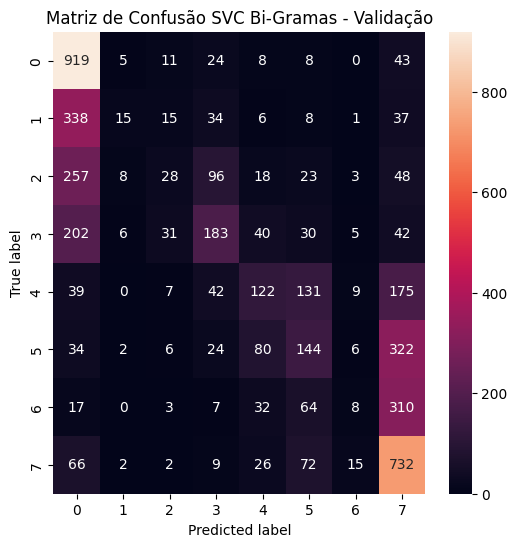

In [31]:
plotMatriz(svc_bg,DocsValTest_bg,yValTest_bg,'Matriz de Confusão SVC Bi-Gramas - Validação')

Os resultados da validação do modelo LinearSVC com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevadas para a classe "1" (0.49 e 0.90, respetivamente), enquanto outras classes, como a classe "9", apresentam valores significativamente inferiores (0.17 e 0.02). A accuracy global é de 43%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias como as "1","2" e "3" que marcam muitas das suas críticas na classe "0", indicando que o modelo enfrenta dificuldades em distinguir entre estas categorias, sendo possivel observar o mesmo para as classes "4","5" e "6" que marcam muitas das suas críticas na classe "7".

## SVC - Bi-Gramas - Teste

In [32]:
svc_bg.fit(DocsTrain_bg,ytrain_bg)
print(svc_bg.score(DocsTrain_bg,ytrain_bg))
print(svc_bg.score(DocsTest_bg,ytest_bg))

0.79272
0.43612


              precision    recall  f1-score   support

           1       0.49      0.89      0.63      5022
           2       0.22      0.02      0.04      2302
           3       0.32      0.08      0.13      2541
           4       0.35      0.33      0.34      2635
           7       0.34      0.22      0.27      2307
           8       0.28      0.21      0.24      2850
           9       0.23      0.01      0.03      2344
          10       0.48      0.83      0.61      4999

    accuracy                           0.44     25000
   macro avg       0.34      0.33      0.29     25000
weighted avg       0.37      0.44      0.36     25000



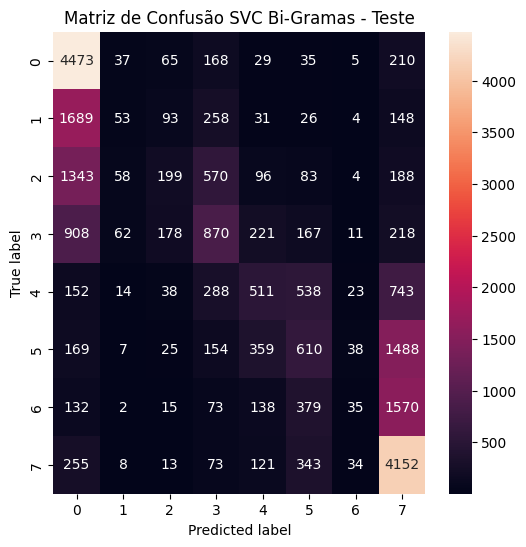

In [33]:
plotMatriz(svc_bg,DocsTest_bg,ytest_bg,'Matriz de Confusão SVC Bi-Gramas - Teste')

Os resultados de teste do modelo LinearSVC com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevadas para a classe "1" (0.49 e 0.89, respetivamente), enquanto outras classes, como a classe "2", apresentam valores significativamente inferiores (0.22 e 0.02). A accuracy global é de 44%, tendo em conta a complexidade do problema é um resultado satisfatório. A matriz de confusão evidencia uma tendência para confusão entre classes intermediárias como as "1","2" e "3" que marcam muitas das suas críticas na classe "0", indicando que o modelo enfrenta dificuldades em distinguir entre estas categorias, sendo possivel observar o mesmo para as classes "4","5" e "6" que marcam muitas das suas críticas na classe "7".

---

<a id='subsection26'></a>
## <center><b>Regressão - Bi-Gramas</b></center>
<div style="text-align: justify">

## SVR - Bi-Gramas - Validação

              precision    recall  f1-score   support

           1       0.72      0.24      0.36      1018
           2       0.18      0.15      0.16       454
           3       0.19      0.22      0.20       481
           4       0.24      0.53      0.34       539
           7       0.21      0.56      0.31       525
           8       0.24      0.24      0.24       618
           9       0.20      0.18      0.19       441
          10       0.60      0.13      0.21       924

    accuracy                           0.27      5000
   macro avg       0.32      0.28      0.25      5000
weighted avg       0.39      0.27      0.26      5000



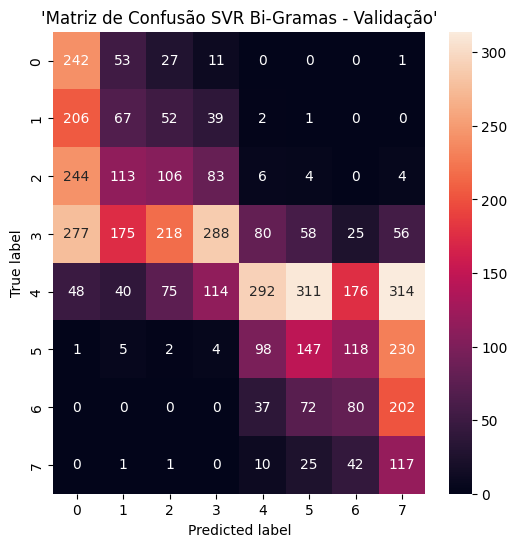

0.8071668832637967
0.6431361230845003


In [34]:
linearSVR_bg =LinearSVR(C=1.0,dual=True,epsilon=0.5,loss='epsilon_insensitive',max_iter=2000,random_state=18)
linearSVR_bg.fit(DocsValTrain_bg,yValTrain_bg)

plotMatrizRegression(linearSVR_bg,DocsValTest_bg,yValTest_bg,"'Matriz de Confusão SVR Bi-Gramas - Validação'")

print(linearSVR_bg.score(DocsValTrain_bg,yValTrain_bg))
print(linearSVR_bg.score(DocsValTest_bg,yValTest_bg))

Os resultados de validação do modelo LinearSVR com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão mais elevada para a classe "1" (0.72) sendo que a recall é mais elevada na classe "7" com 0.56. A accuracy global é de 27% o que pode indicar este modelo não ser adequado para este tipo de problemas. Na matriz de confusão existe uma maior variação de resultados podendo observar nas classes 3 e 4 (4 e 7 na classes do problema) onde acabam por prever um bocado por todas as classes existentes, a 3 com as 3 primeiras classes e a 4 com as 3 ultimas classes.

## SVR - Bi-Gramas - Teste

              precision    recall  f1-score   support

           1       0.69      0.21      0.32      5022
           2       0.20      0.17      0.18      2302
           3       0.19      0.20      0.20      2541
           4       0.23      0.55      0.33      2635
           7       0.19      0.57      0.29      2307
           8       0.23      0.25      0.24      2850
           9       0.20      0.15      0.17      2344
          10       0.65      0.12      0.20      4999

    accuracy                           0.25     25000
   macro avg       0.32      0.28      0.24     25000
weighted avg       0.39      0.25      0.24     25000



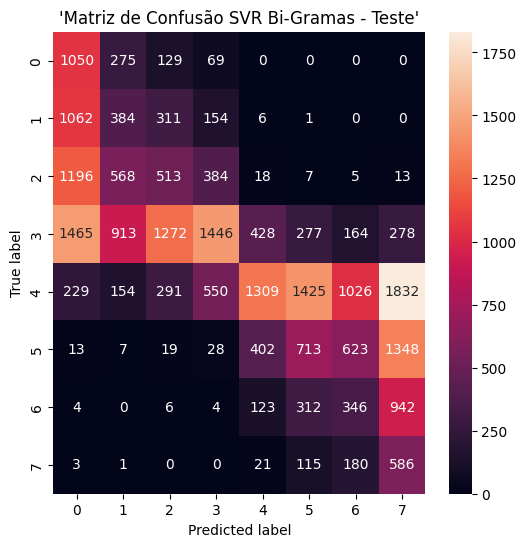

0.8085046747013934
0.638456698788753


In [35]:
linearSVR_bg.fit(DocsTrain_bg,ytrain_bg)
plotMatrizRegression(linearSVR_bg,DocsTest_bg,ytest_bg,"'Matriz de Confusão SVR Bi-Gramas - Teste'")
print(linearSVR_bg.score(DocsTrain_bg,ytrain_bg))
print(linearSVR_bg.score(DocsTest_bg,ytest_bg))

Os resultados de teste do modelo LinearSVR com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão mais elevada para a classe "1" (0.69) sendo que a recall é mais elevada na classe "7" com 0.57. A accuracy glboal é de 25% o que pode indicar este modelo não ser adequado para este tipo de problemas, tendo ainda uma pior percentagem que na validação. Na matriz de confusão existe uma maior variação de resultados podendo-se observar nas classes 3 e 4 (4 e 7 na classes do problema) onde acabam por prever um bocado por todas as classes existentes, a "3" com as 3 primeiras classes e a "4" com as 3 últimas classes.

---

## Linear Regression - Bi-Gramas - Validação

              precision    recall  f1-score   support

           1       0.66      0.33      0.44      1018
           2       0.21      0.19      0.20       454
           3       0.21      0.20      0.21       481
           4       0.24      0.48      0.32       539
           7       0.21      0.45      0.29       525
           8       0.24      0.20      0.22       618
           9       0.22      0.24      0.23       441
          10       0.54      0.24      0.33       924

    accuracy                           0.29      5000
   macro avg       0.32      0.29      0.28      5000
weighted avg       0.37      0.29      0.30      5000



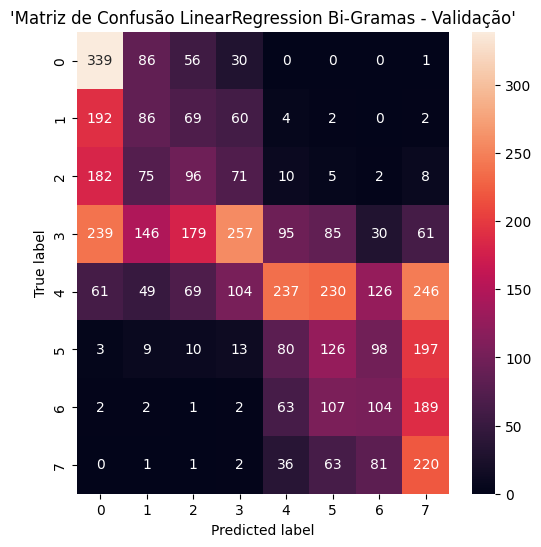

0.9999979240327583
0.5989160669267527


In [36]:
linearRegression_bg = LinearRegression(copy_X=True,fit_intercept=True,positive=False)

linearRegression_bg.fit(DocsValTrain_bg,yValTrain_bg)

plotMatrizRegression(linearRegression_bg,DocsValTest_bg,yValTest_bg,"'Matriz de Confusão LinearRegression Bi-Gramas - Validação'")

print(linearRegression_bg.score(DocsValTrain_bg,yValTrain_bg))
print(linearRegression_bg.score(DocsValTest_bg,yValTest_bg))


Os resultados de validação do modelo LinearRegression apresentam um desempenho variável entre as classes, com uma precisão mais elevada na classe 1 e um recall mais elevado na classe 4. A accuracy global é de 29%, o que significa que não é o pior resultado entre os 4 modelos comparando com a não utilização de bi-gramas.  Na matriz de confusão existe uma maior variação de resultados podendo-se observar nas classes 3 e 4 (4 e 7 na classes do problema) onde acabam por prever um bocado por todas as classes existentes, a "3" com as 3 primeiras classes e a "4" com as 3 últimas classes.


## Linear Regression - Bi-Gramas - Teste

              precision    recall  f1-score   support

           1       0.62      0.30      0.40      5022
           2       0.20      0.18      0.19      2302
           3       0.19      0.19      0.19      2541
           4       0.19      0.42      0.26      2635
           7       0.17      0.44      0.25      2307
           8       0.22      0.21      0.22      2850
           9       0.19      0.16      0.18      2344
          10       0.58      0.20      0.30      4999

    accuracy                           0.26     25000
   macro avg       0.30      0.26      0.25     25000
weighted avg       0.36      0.26      0.27     25000



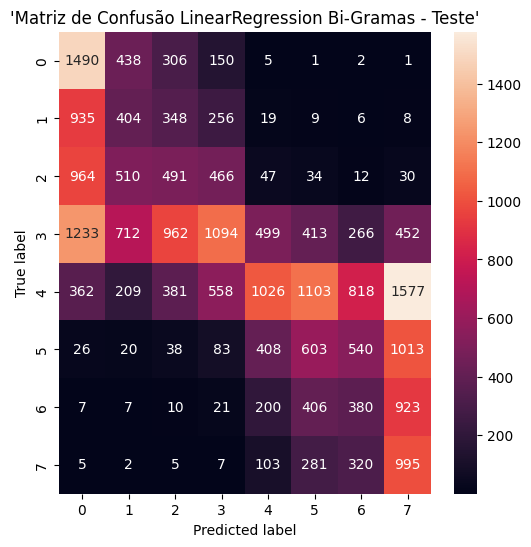

Score treino:  0.9999983355502899
Score teste:  0.5679339178735356


In [37]:
linearRegression_bg.fit(DocsTrain_bg, ytrain_bg)

plotMatrizRegression(linearRegression_bg,DocsTest_bg,ytest_bg,"'Matriz de Confusão LinearRegression Bi-Gramas - Teste'")

print('Score treino: ', linearRegression_bg.score(DocsTrain_bg, ytrain_bg))
print('Score teste: ', linearRegression_bg.score(DocsTest_bg, ytest_bg))


Os resultados de teste do modelo Linear Regression com bi-gramas apresentam um desempenho variável entre as classes, com uma precisão e recall mais elevados para a classe "1" (0.23 e 0.49, respetivamente). A accuracy glboal é de 26%, não sendo tambem em teste o pior valor nos 4 modelos testados. Na matriz de confusão existe uma grande variação nas True Labels 3 e 4 onde se prevê um bocado por todas as classes existentes, nas classes 0,1 e 2 onde não consegue destinguir com uma grande performance entre as classes 0,1,2 e 3 sendo igual para as classes 5,6 e 7 onde não consegue destinguir com boa performance nas classes 4,5,6 e 7.

---

<a id='subsection27'></a>
## <center><b>Comparação de Resultados</b></center>
<div style="text-align: justify">

A comparação dos resultados obtidos com e sem bi-gramas para os quatro modelos (Logistic Regression, LinearSVC, LinearSVR e Linear Regression) evidencia algumas diferenças que refletem o impacto da inclusão de bi-gramas.

### Logistic Regression
Ao comparar os desempenhos com e sem bi-gramas, o modelo Logistic Regression apresenta um ligeiro aumento na accuracy global (de 43% para 44%).

### LinearSVC
No caso do LinearSVC, a inclusão de bi-gramas trouxe um pequeno aumento na accuracy global (de 42% para 44%).

### LinearSVR
Para o modelo LinearSVR, a inclusão de bi-gramas não trouxe melhorias substanciais, uma vez que a accuracy global permaneceu em 25%.

### Linear Regression
No modelo Linear Regression, a inclusão de bi-gramas trouxe uma ligeira melhoria na accuracy global, que passou de 21% para 26%. <br>
<br>


| Modelo              | Accuracy (sem bi-gramas) | Melhor Recall (Classe) sem bi-gramas | Accuracy (com bi-gramas) | Melhor Recall (Classe) com bi-gramas |
|---------------------|--------------------------|--------------------------------------|---------------------------|---------------------------------------|
| Logistic Regression | 43%                     | 0.82 (Classe "1")                   | 44%                      | 0.87 (Classe "1")                    |
| LinearSVC           | 42%                     | 0.86 (Classe "1")                   | 44%                      | 0.89 (Classe "1")                    |
| LinearSVR           | 25%                     | 0.54 (Classe "7")                   | 25%                      | 0.57 (Classe "7")                    |
| Linear Regression   | 21%                     | 0.49 (Classe "1")                   | 26%                      | 0.49 (Classe "1")                    |


<br>

Os resultados obtidos demonstram que os modelos de classificação, Logistic Regression e LinearSVC, apresentam melhores desempenhos face aos modelos de regressão, LinearSVR e Linear Regression, tanto em termos de accuracy global como de recall por classe. Os classificadores conseguiram alcançar accuracy de até 44%, com recalls mais elevados em classes específicas, como a classe "1" (até 0.89 no caso do LinearSVC com bi-gramas). Por outro lado, os modelos de regressão apresentam accuracy mais baixas, com o melhor valor sendo apenas 26% no caso do Linear Regression com bi-gramas.

Estes resultados reforçam que os métodos de classificação são mais adequados para problemas multi-classes como este. A inclusão de bi-gramas melhorou um pouco o desempenho de todos os modelos, mas não alterou a tendência geral de que os classificadores são mais eficazes do que os regressões para este problema.


---

<a id='subsection28'></a>
## <center><b>Clustering</b></center>
<div style="text-align: justify">

Clustering é uma técnica de aprendizagem não supervisionada que tem como objetivo agrupar os dados em grupos, ou "clusters", de forma que os elementos dentro de um mesmo grupo sejam mais semelhantes entre si do que aos de outros grupos. Diferentemente de métodos supervisionados, como classificação ou regressão, o clustering não utiliza rótulos conhecidos nos dados, sendo particularmente útil para explorar padrões ou relações desconhecidas.

No contexto deste trabalho, o clustering foi utilizado para identificar possíveis agrupamentos nas críticas de filmes com base em suas características textuais. A ideia subjacente é verificar se é possível organizar as críticas em grupos coesos, que possam refletir preferências ou estilos de avaliação dos utilizadores, sem a necessidade de rótulos pré-definidos.

O K-Means agrupa os dados em k clusters pré-definidos, minimizando a soma das distâncias quadradas entre os pontos e os centróides dos clusters.

### Parâmetros do K-Means

### n_clusters: int, default=8
Número de clusters a serem formados

### init: {‘k-means++’, ‘random’}, default=’k-means++’
Método de inicialização dos centróides:

- ‘k-means++’: Escolhe os centróides iniciais de forma a acelerar a convergência.
- ‘random’: Seleciona os centróides iniciais aleatoriamente.

### max_iter: int, default=300
Número máximo de iterações que o algoritmo realizará em uma única execução para garantir a convergência.

### n_init: int, default=10
Número de vezes que o algoritmo será executado com inicializações diferentes. O melhor resultado, baseado na inércia (soma das distâncias ao quadrado), será escolhido.

### tol: float, default=1e-4
Critério de tolerância para a convergência. Se a diferença na inércia entre duas iterações consecutivas for menor que este valor, o algoritmo é considerado convergente.

### algorithm: {‘lloyd’, ‘elkan’, ‘auto’, ‘full’}, default=’lloyd’
Define o algoritmo utilizado para atualizar os clusters:

- ‘lloyd’: Algoritmo clássico do K-Means.
- ‘elkan’: Versão otimizada que usa triângulos para reduzir cálculos de distância (mais eficiente em alguns casos).
- ‘auto’ ou ‘full’: Escolhe automaticamente o algoritmo com base nos dados.

### random_state: int ou None, default=None
Controla a geração de números aleatórios para a inicialização dos centróides.

In [38]:
kmeans = KMeans(n_clusters=10,init='k-means++',n_init=5,max_iter=1000,tol=.00001,verbose=0,random_state=18)
kmeans = kmeans.fit(X,y=y)
C = kmeans.cluster_centers_
labels = kmeans.labels_

In [39]:
Xdense = X.toarray()
print(Xdense.shape)
print(labels.shape)
for i in range((10)):
    print(len(Xdense[labels==i]))

(50000, 25759)
(50000,)
3951
4206
4969
1453
4504
9919
8295
2880
5100
4723


In [40]:

for cluster in range(10):
    print(f"\nCluster {cluster}:")

    cluster_docs = [doc for i, doc in enumerate(DocsFinal) if labels[i] == cluster]
    for idx, doc in enumerate(cluster_docs[:20]):
        print(f"Document {idx + 1}: {doc}\n")



Cluster 0:
Document 1: A chemical spill is turning people into zombies It s up to two doctor s to survive the epidemic It s an Andreas Schnaas film so you know what the par for the course will be Bad acting horribly awful special effects and no budget to speak of The dubbing is ridiculous with a capital R and the saddest thing is that I feel compelled to write one word about this piece of excrement much less the ten lines mandatory because of the guidelines placed on me by IMDb My original review of merely one word Crap wouldn t fly so I have to revise it and go more in to how bad it is But I don t know if I can so wait I think I may have enough words or lines rather to make this review pass Which is cool I guess So in summation This movie sucks balls don t watch it My Grade F

Document 2: this is one amazing movie you have to realize that chinese folklore is complicated and philosophical there are always stories behind stories i myself did not understand everything but knowing chines


Foi, então, realizada uma análise dos clusters obtido com o objetivo de identificar padrões e/ou categorias recorrentes nos comentários. Abaixo, apresentam-se os resultados do clustering com 10 clusters, os quais refletem diversas vertentes das opiniões expressas pelos críticos:

- Cluster 0 - Zombies, Monstros: Este cluster agrupa as críticas relacionadas com filmes de terror e monstros.

- Cluster 1 - Discussão sobre os Atores e suas Atuações: As críticas agrupadas neste cluster centram-se nas atuações dos atores e na apreciação dos seus papéis nos filmes.

- Cluster 2 - Críticas Negativas: Este cluster reúne críticas negativas.

- Cluster 3 - Nostalgia, Séries e Comédia: As críticas neste cluster abordam temas de nostalgia, com ênfase na importância das séries e da comédia, refletindo uma apreciação por filmes que evocam memórias e proporcionam entretenimento leve.

- Cluster 4 - Dualidade de Críticas:  As críticas aqui reunidas destacam uma ambiguidade nas reações dos críticos em relação aos filmes.

- Cluster 5 - Críticas das Narrativas: As críticas neste cluster centram-se nas narrativas e elencos dos filmes.

- Cluster 6 - Críticas Negativas: Semelhante ao Cluster 2, este grupo contém críticas negativas.

- Cluster 7 - Dramas: Este cluster é composto por críticas a filmes do género dramático.

- Cluster 8 - Críticas Negativas: Este cluster, tal como o Cluster 2 e o Cluster 6, inclui críticas predominantemente Negativas

- Cluster 9 - Críticas Negativas: Este grupo, à semelhança dos Clusters 2,6 e 8, inclui críticas predominantemente Negativas


In [41]:
kmeans = KMeans(n_clusters=5,init='k-means++',n_init=5,max_iter=1000,tol=.00001,verbose=0,random_state=18)
kmeans = kmeans.fit(X,y=y)
C = kmeans.cluster_centers_
labels = kmeans.labels_

In [42]:
Xdense = X.toarray()
print(Xdense.shape)
print(labels.shape)
for i in range((5)):
    print(len(Xdense[labels==i]))

(50000, 25759)
(50000,)
9233
7154
16532
13482
3599


In [43]:

for cluster in range(5):
    print(f"\nCluster {cluster}:")


    cluster_docs = [doc for i, doc in enumerate(DocsFinal) if labels[i] == cluster]
    for idx, doc in enumerate(cluster_docs[:20]):
        print(f"Document {idx + 1}: {doc}\n")


Cluster 0:
Document 1: Words can t describe how bad this movie is I can t explain it by writing only You have too see it for yourself to get at grip of how horrible a movie really can be Not that I recommend you to do that There are so many clichés mistakes and all other negative things you can imagine here that will just make you cry To start with the technical first there are a LOT of mistakes regarding the airplane I won t list them here but just mention the coloring of the plane They didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original Boeing livery Very bad The plot is stupid and has been done many times before only much much better There are so many ridiculous moments here that i lost count of it really early Also I was on the bad guys side all the time in the movie because the good guys were so stupid Executive Decision should without a doubt be you re choice over this one even the Turbulence -movies are better I

A seguir, apresentamos os resultados do clustering com 5 clusters, que revelam os temas mais recorrentes nas críticas analisadas:

- Cluster 0 - Dualidade de Críticas: As críticas aqui reunidas destacam uma ambiguidade nas reações dos críticos em relação aos filmes.

- Cluster 1 - Críticas Negativas: As críticas agrupadas neste cluster são predominantemente negativas, com ênfase nas falhas dos filmes, quer em termos de elenco, quer nas atuações e à direção.

- Cluster 2 - Críticas de Ficção Científica, Comédia, Ação e Dramas

- Cluster 3 - Críticas Negativas

- Cluster 4 - Críticas de Personagens e Atuações: As críticas agrupadas neste cluster focam-se nas personagens e nas atuações dos atores. São avaliadas as personagens, bem como a capacidade dos atores de dar vida a esses papéis.

---
<a id='section3'></a>
## <center><b>Conclusão</b></center>
<div style="text-align: justify">


Em conclusão, este segundo trabalho prático permitiu-nos aplicar tanto aplicar os conceitos teóricos lecionados em aula como os laboratórios e fichas realizadas sobre modelos de classificação e regressão para aprendizagem automática e clustering de modo a poder separar as críticas em diferentes tópicos.

Foi possivel aprofundar ainda mais o conhecimento de várias bibliotecas python como o sklearn que contém as funções necessárias para o bom funcionamento do nosso trabalho.

Sentimos que realizámos um bom trabalho que tenta responder à questão deste trabalho mesmo que os resultados não sejam excelentes pela complexidade do dataset utilizado e a questão a que tentamos responder.

<a id='section4'></a>
## <center><b>Bibliografia</b></center>
<div style="text-align: justify">

[Slides e vídeos da unidade curricular disponibilizados pelos docentes;](https://2425moodle.isel.pt/course/view.php?id=8219)\
[Documentação Logistic Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)\
[Documentação LinearSVC- Linear Support Vector Classification](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.LinearSVC.html)\
[Documentação LinearSVR- Linear Support Vector Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.LinearSVR.html)\
[Documentação Linear Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html)\
[Documentação K-Means](https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html)
